In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
import scanpy as sc
import squidpy as sq
import anndata as ad
import scipy as sp

In [2]:
dataset = '43_slide_tag_human_tonsil'

In [3]:
adata = sc.read_10x_mtx(f'../../data/reference_data/{dataset}')
adata

AnnData object with n_obs × n_vars = 9360 × 36601
    var: 'gene_ids', 'feature_types'

In [4]:
adata.obs_names

Index(['AAACCCAAGCCTCTGG-1', 'AAACCCAAGCGCCTTG-1', 'AAACCCAAGTGGACGT-1',
       'AAACCCACAGAAGTGC-1', 'AAACCCACAGCCGTTG-1', 'AAACCCAGTCATTGCA-1',
       'AAACCCATCATCGCAA-1', 'AAACCCATCCGATCGG-1', 'AAACCCATCGGTTAGT-1',
       'AAACGAAAGTGCAGGT-1',
       ...
       'TTTGGTTCATGTGACT-1', 'TTTGGTTGTACAGCGA-1', 'TTTGGTTGTCCACACG-1',
       'TTTGGTTTCGGAGTAG-1', 'TTTGTTGAGTAGGAAG-1', 'TTTGTTGCAGGGACTA-1',
       'TTTGTTGCATTGTAGC-1', 'TTTGTTGGTACCACGC-1', 'TTTGTTGGTCTGTCCT-1',
       'TTTGTTGTCATGCGGC-1'],
      dtype='object', length=9360)

In [5]:
df = pd.read_csv(f'../../data/reference_data/{dataset}/HumanTonsil_spatial.csv', skiprows=1)
df = df.set_index('TYPE')
df.columns = ['spatial1', 'spatial2', 'cell_type']

In [6]:
df.head()

,spatial1,spatial2,cell_type
TYPE,,,
AAACCCAAGCGCCTTG-1,1733.213235,1665.039824,T_CD4
AAACCCAAGTGGACGT-1,519.377858,2220.266321,plasma
AAACCCACAGAAGTGC-1,1064.296595,2158.266703,B_germinal_center
AAACCCAGTCATTGCA-1,1740.127314,3218.472808,B_naive
AAACCCATCATCGCAA-1,930.600158,2892.947737,B_memory


In [7]:
sel_cells = list(set(df.index) & set(adata.obs_names))

In [8]:
len(sel_cells)

5778

In [9]:
df = df.loc[sel_cells, ]
adata = adata[sel_cells, ]

In [10]:
adata.obs = df
adata.obsm['spatial'] = df[['spatial2', 'spatial1']].values

In [11]:
sc.pp.calculate_qc_metrics(adata, inplace=True)

In [12]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=50)

In [13]:
adata

AnnData object with n_obs × n_vars = 5778 × 17759
    obs: 'spatial1', 'spatial2', 'cell_type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_genes'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    obsm: 'spatial'

In [14]:
adata.layers['counts'] = adata.X.copy()

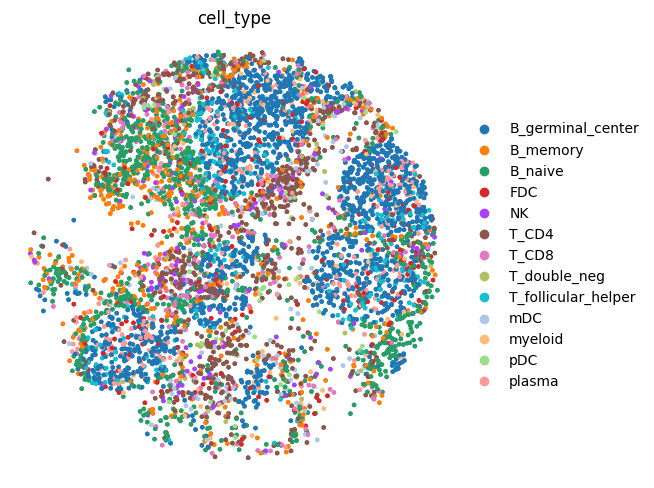

In [15]:
sq.pl.spatial_scatter(adata, color=['cell_type'], shape=None, frameon=False)

In [16]:
# remove MT genes
non_mito_genes_list = [name for name in adata.var_names if not name.startswith('MT-')]
adata = adata[:, non_mito_genes_list]

In [17]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [18]:
adata

AnnData object with n_obs × n_vars = 5778 × 17746
    obs: 'spatial1', 'spatial2', 'cell_type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_genes'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'cell_type_colors', 'log1p'
    obsm: 'spatial'
    layers: 'counts'

In [19]:
sq.gr.spatial_neighbors(adata, coord_type="grid", delaunay=False)
sq.gr.spatial_autocorr(adata, mode="moran", 
                       n_perms=100, n_jobs=10, 
                       genes=adata.var_names)

100%|██████████| 100/100 [00:39<00:00,  2.55/s]


In [20]:
adata.uns["moranI"]

,I,pval_norm,var_norm,pval_z_sim,pval_sim,var_sim,pval_norm_fdr_bh,pval_z_sim_fdr_bh,pval_sim_fdr_bh
AC023590.1,0.529340,0.000000,0.000095,0.000000e+00,0.009901,0.000121,0.000000,0.000000,0.037123
RGS13,0.528968,0.000000,0.000095,0.000000e+00,0.009901,0.000110,0.000000,0.000000,0.037123
AFF2,0.513168,0.000000,0.000095,0.000000e+00,0.009901,0.000112,0.000000,0.000000,0.037123
SAMD12,0.500655,0.000000,0.000095,0.000000e+00,0.009901,0.000118,0.000000,0.000000,0.037123
AL390957.1,0.455046,0.000000,0.000095,0.000000e+00,0.009901,0.000111,0.000000,0.000000,0.037123
...,...,...,...,...,...,...,...,...,...
AKAP10,-0.025070,0.005314,0.000095,1.500375e-04,0.009901,0.000046,0.026280,0.000794,0.037123
PAN2,-0.026379,0.003583,0.000095,3.839133e-05,0.009901,0.000047,0.018757,0.000225,0.037123
ZNF384,-0.026455,0.003500,0.000095,4.486097e-05,0.009901,0.000044,0.018354,0.000260,0.037123
PRPF18,-0.026882,0.003066,0.000095,5.590533e-05,0.009901,0.000047,0.016421,0.000318,0.037123


In [21]:
n_svgs = 50
sel_genes = (
    adata.uns["moranI"]["I"].sort_values(ascending=False).head(n_svgs).index.tolist()
)

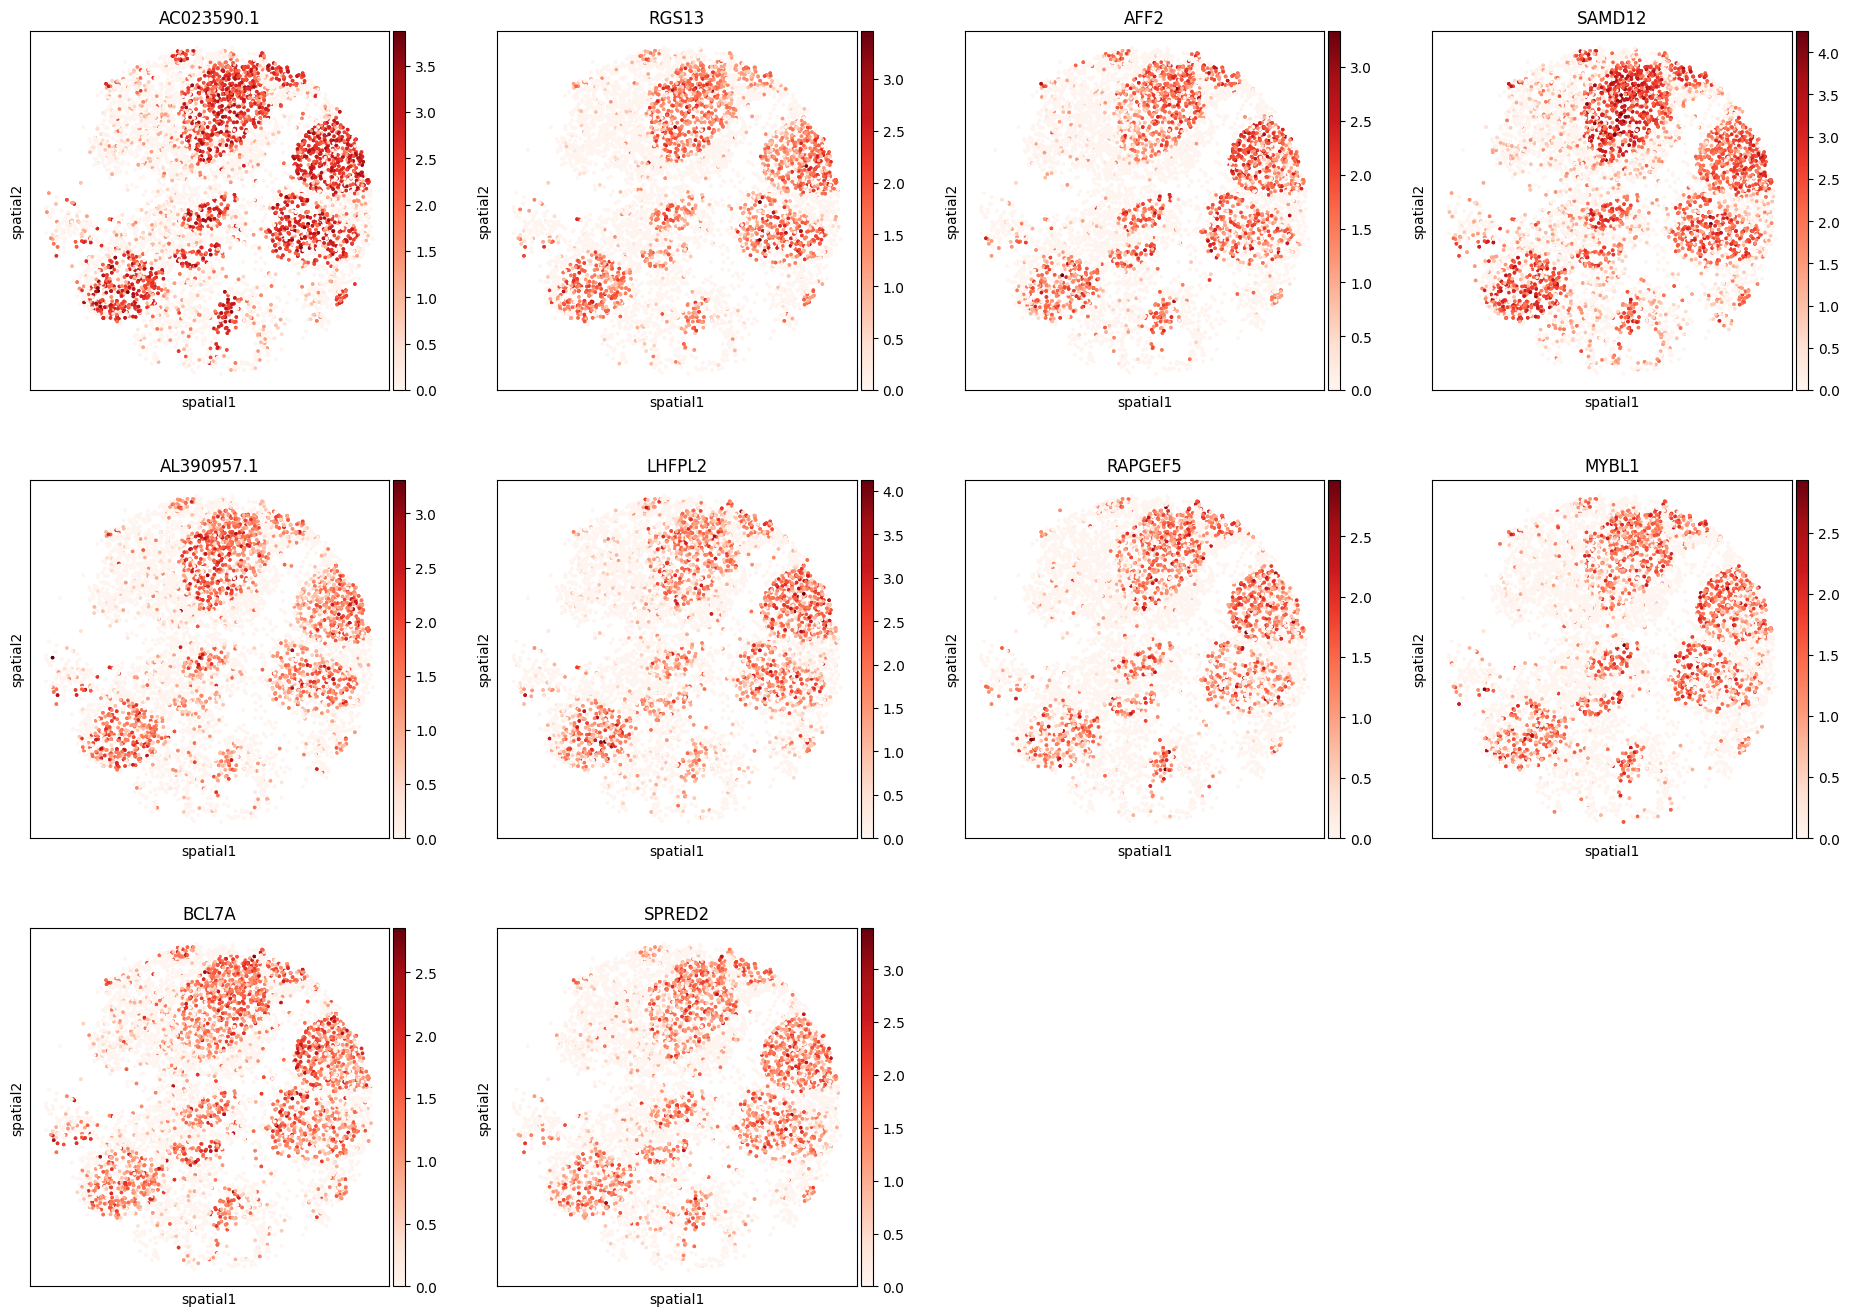

In [22]:
sq.pl.spatial_scatter(
    adata, color=sel_genes[:10], figsize=(5, 5), size=10, 
    cmap="Reds", shape=None,
)

In [23]:
# select top 50 variable genes as reference
adata = adata[:, sel_genes]

In [24]:
adata

View of AnnData object with n_obs × n_vars = 5778 × 50
    obs: 'spatial1', 'spatial2', 'cell_type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_genes'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'cell_type_colors', 'log1p', 'spatial_neighbors', 'moranI'
    obsm: 'spatial'
    layers: 'counts'
    obsp: 'spatial_connectivities', 'spatial_distances'

In [25]:
adata.write_h5ad(f'../../results/00_prepare_reference_data/{dataset}.h5ad')